# Get BERT Embeddings

In [ ]:
# add epochs

In [1]:
import gensim
import logging
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api # Downloading the Google pretrained Word2Vec Model

In [2]:
import numpy as np
import requests
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
import os
import json
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

references: https://medium.com/analytics-vidhya/recommendation-system-using-bert-embeddings-1d8de5fc3c56

BERT is a NLP model developed by Google for pre-training language representations. It leverages an enormous amount of plain text data publicly available on the web and is trained in an unsupervised manner. Pre-training a BERT model is a fairly expensive yet one-time procedure for each language. Fortunately, Google released several pre-trained model.

In [5]:
#requirements of text: lower, alphanumeric characters

For creating word embeddings we will be using pretrained BERT embeddings which are hosted on Tensorflow hub and can be downloaded for fine tuning, transfer learning etc.

Finally, bert-as-service uses BERT as a sentence encoder and hosts it as a service via ZeroMQ, allowing you to map sentences into fixed-length representations in just two lines of code.

In [6]:
pip install bert-serving-server --no-deps

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
MODEL_DIR = '/content/uncased_L-12_H-768_A-12' 
GRAPH_DIR = '/content/graph/' 
GRAPH_OUT = 'extractor.pbtxt' 

In [9]:
import os
import tensorflow as tf
#sesh = tf.compat.v1.InteractiveSession()

from bert_serving.server.graph import optimize_graph
from bert_serving.server.helper import get_args_parser

2022-04-01 18:25:18.986040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 18:25:18.986124: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/vkanoria/anaconda3/lib/python3.9/site-packages/bert_serving/server/helper.py:175: UserWarning: Tensorflow 2.8.0 is not tested! It may or may not work. Feel free to submit an issue at https://github.com/hanxiao/bert-as-service/issues/
  warnings.warn('Tensorflow %s is not tested! It may or may not work. '


In [10]:
import logging
import numpy as np

tf.Session() initiates a TensorFlow Graph object in which tensors are processed through operations (or ops). The with block terminates the session as soon as the operations are completed. Hence, there is no need for calling Session.close . Also, a session contains variables, global variables, placeholders, and ops.

In [11]:
SEQ_LEN = '256' 

https://www.kaggle.com/nikhil00/eda-use-bert-recommendation-system

In [12]:
## install required libraries for BERT
#!pip install transformers
#!wget -O scibert_uncased.tar https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar
#!tar -xvf scibert_uncased.tar

In [13]:
#pip install torch

In [14]:
## import libraries
import torch
from transformers import BertTokenizer, BertModel
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# Let's load pretrained BERT model
model_version = 'scibert_scivocab_uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version,do_lower_case=do_lower_case)

Some weights of the model checkpoint at scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokeni

## Citation:
@inproceedings{beltagy-etal-2019-scibert,
    title = "SciBERT: A Pretrained Language Model for Scientific Text",
    author = "Beltagy, Iz  and Lo, Kyle  and Cohan, Arman",
    booktitle = "EMNLP",
    year = "2019",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D19-1371"
}

In [16]:
#Read dataset
temp_df = pd.read_csv('unique_books.csv')

In [17]:
temp_df.head()

,Unnamed: 0,user_id,book_id,rating,SortIndex1,SortIndex2,goodreads_book_id,isbn,isbn13,original_title,average_rating,ratings_count,book_authors,book_desc,book_isbn,book_title,genres,book_desc_tok
0,0,2,2318,3,41929,398,998.0,671015206,9.780671e+12,The Millionaire Next Door: The Surprising Secr...,4.00,43937.0,"['Thomas J. Stanley', 'William D. Danko']",The incredible national bestseller that is cha...,9.780670e+12,The Millionaire Next Door: The Surprising Secr...,"['Economics', 'Finance', 'Nonfiction', 'Busine...",the incredible national bestseller ...
1,389,2,26,4,41929,227,968.0,307277674,9.780307e+12,The Da Vinci Code,3.79,1447148.0,['Dan Brown'],An ingenious code hidden in the works of Leona...,9.780310e+12,The Da Vinci Code,"['Fiction', 'Mystery', 'Thriller']",an ingenious code hidden in t...
2,13461,2,315,3,41929,193,4894.0,91883768,9.780092e+12,Who Moved My Cheese?,3.74,237272.0,"['Spencer Johnson', 'Kenneth H. Blanchard']","Written by Spencer Johnson, coauthor of The On...",9.780090e+12,Who Moved My Cheese?,"['Business', 'Self Help', 'Nonfiction', 'Psych...",written by spencer johnson ...
3,15287,2,33,4,41929,98,930.0,739326228,9.780739e+12,Memoirs of a Geisha,4.08,1300209.0,['Arthur Golden'],"A literary sensation and runaway bestseller, t...",9.780740e+12,Memoirs of a Geisha,"['Fiction', 'Historical', 'Historical Fiction'...",a literary sensation and runaway...
4,49199,2,301,5,41929,194,4900.0,1892295490,9.781892e+12,Heart of Darkness,3.42,255576.0,['Joseph Conrad'],Dark allegory describes the narrator's journey...,9.781890e+12,Heart of Darkness,"['Classics', 'Fiction', 'Literature', 'Cultura...",dark allegory describes the narr...


In [18]:
temp_df['tokens'] = np.nan
temp_df['num_of_tokens'] = 0
temp_df['book_desc_tok_short'] = ''
temp_df


,Unnamed: 0,user_id,book_id,rating,SortIndex1,SortIndex2,goodreads_book_id,isbn,isbn13,original_title,...,ratings_count,book_authors,book_desc,book_isbn,book_title,genres,book_desc_tok,tokens,num_of_tokens,book_desc_tok_short
0,0,2,2318,3,41929,398,998.0,671015206,9.780671e+12,The Millionaire Next Door: The Surprising Secr...,...,43937.0,"['Thomas J. Stanley', 'William D. Danko']",The incredible national bestseller that is cha...,9.780670e+12,The Millionaire Next Door: The Surprising Secr...,"['Economics', 'Finance', 'Nonfiction', 'Busine...",the incredible national bestseller ...,NaN,0,
1,389,2,26,4,41929,227,968.0,307277674,9.780307e+12,The Da Vinci Code,...,1447148.0,['Dan Brown'],An ingenious code hidden in the works of Leona...,9.780310e+12,The Da Vinci Code,"['Fiction', 'Mystery', 'Thriller']",an ingenious code hidden in t...,NaN,0,
2,13461,2,315,3,41929,193,4894.0,91883768,9.780092e+12,Who Moved My Cheese?,...,237272.0,"['Spencer Johnson', 'Kenneth H. Blanchard']","Written by Spencer Johnson, coauthor of The On...",9.780090e+12,Who Moved My Cheese?,"['Business', 'Self Help', 'Nonfiction', 'Psych...",written by spencer johnson ...,NaN,0,
3,15287,2,33,4,41929,98,930.0,739326228,9.780739e+12,Memoirs of a Geisha,...,1300209.0,['Arthur Golden'],"A literary sensation and runaway bestseller, t...",9.780740e+12,Memoirs of a Geisha,"['Fiction', 'Historical', 'Historical Fiction'...",a literary sensation and runaway...,NaN,0,
4,49199,2,301,5,41929,194,4900.0,1892295490,9.781892e+12,Heart of Darkness,...,255576.0,['Joseph Conrad'],Dark allegory describes the narrator's journey...,9.781890e+12,Heart of Darkness,"['Classics', 'Fiction', 'Literature', 'Cultura...",dark allegory describes the narr...,NaN,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,6862729,30013,7467,4,24827,294,28016509.0,425285049,9.780425e+12,The Girl Before,...,23500.0,['J.P. Delaney'],"In the tradition of The Girl on the Train, The...",9.780430e+12,The Girl Before,"['Thriller', 'Mystery', 'Fiction', 'Suspense',...",in the tradition of the girl ...,NaN,0,
4323,6862861,6120,6443,3,43815,182,30008702.0,385542070,9.780386e+12,Nutshell,...,10904.0,['Ian McEwan'],Nutshell is a classic story of murder and dece...,9.780390e+12,Nutshell,"['Fiction', 'Contemporary', 'Mystery', 'Litera...",nutshell is a classic story o...,NaN,0,
4324,6863071,31288,6428,5,33660,87,31538635.0,1781106282,9.781781e+12,"Short Stories from Hogwarts of Heroism, Hardsh...",...,16285.0,"['J.K. Rowling', 'MinaLima']",‘Minerva was the Roman goddess of warriors and...,9.781780e+12,"Short Stories from Hogwarts of Heroism, Hardsh...","['Fantasy', 'Short Stories', 'Fiction', 'Young...",minerva was the roman goddes...,NaN,0,
4325,6863235,12503,8685,4,3215,37,28965131.0,125011117X,9.781250e+12,Behind Her Eyes,...,17944.0,['Sarah Pinborough'],Why is everyone talking about the ending of Sa...,9.781250e+12,Behind Her Eyes,"['Thriller', 'Mystery', 'Fiction', 'Suspense',...",why is everyone talking about ...,NaN,0,


In [19]:
#Look at length of book descriptions
#Shorten book description to first 333 tokens to match tensor size

for i in range(temp_df.shape[0]):
    temp_df['tokens'][i] = temp_df['book_desc_tok'][i].split()
    temp_df['num_of_tokens'][i] = len(temp_df['tokens'][i])
    temp_df['book_desc_tok_short'][i] = ' '.join(temp_df['tokens'][i][:333])

/tmp/ipykernel_77090/1789939230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['tokens'][i] = temp_df['book_desc_tok'][i].split()
/home/vkanoria/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_77090/1789939230.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['num_of_tokens'][i] = len(

In [20]:
temp_df.head()

,Unnamed: 0,user_id,book_id,rating,SortIndex1,SortIndex2,goodreads_book_id,isbn,isbn13,original_title,...,ratings_count,book_authors,book_desc,book_isbn,book_title,genres,book_desc_tok,tokens,num_of_tokens,book_desc_tok_short
0,0,2,2318,3,41929,398,998.0,671015206,9.780671e+12,The Millionaire Next Door: The Surprising Secr...,...,43937.0,"['Thomas J. Stanley', 'William D. Danko']",The incredible national bestseller that is cha...,9.780670e+12,The Millionaire Next Door: The Surprising Secr...,"['Economics', 'Finance', 'Nonfiction', 'Busine...",the incredible national bestseller ...,"[the, incredible, national, bestseller, that, ...",89,the incredible national bestseller that is cha...
1,389,2,26,4,41929,227,968.0,307277674,9.780307e+12,The Da Vinci Code,...,1447148.0,['Dan Brown'],An ingenious code hidden in the works of Leona...,9.780310e+12,The Da Vinci Code,"['Fiction', 'Mystery', 'Thriller']",an ingenious code hidden in t...,"[an, ingenious, code, hidden, in, the, works, ...",166,an ingenious code hidden in the works of leona...
2,13461,2,315,3,41929,193,4894.0,91883768,9.780092e+12,Who Moved My Cheese?,...,237272.0,"['Spencer Johnson', 'Kenneth H. Blanchard']","Written by Spencer Johnson, coauthor of The On...",9.780090e+12,Who Moved My Cheese?,"['Business', 'Self Help', 'Nonfiction', 'Psych...",written by spencer johnson ...,"[written, by, spencer, johnson, coauthor, of, ...",71,written by spencer johnson coauthor of the one...
3,15287,2,33,4,41929,98,930.0,739326228,9.780739e+12,Memoirs of a Geisha,...,1300209.0,['Arthur Golden'],"A literary sensation and runaway bestseller, t...",9.780740e+12,Memoirs of a Geisha,"['Fiction', 'Historical', 'Historical Fiction'...",a literary sensation and runaway...,"[a, literary, sensation, and, runaway, bestsel...",86,a literary sensation and runaway bestseller th...
4,49199,2,301,5,41929,194,4900.0,1892295490,9.781892e+12,Heart of Darkness,...,255576.0,['Joseph Conrad'],Dark allegory describes the narrator's journey...,9.781890e+12,Heart of Darkness,"['Classics', 'Fiction', 'Literature', 'Cultura...",dark allegory describes the narr...,"[dark, allegory, describes, the, narrator, s, ...",48,dark allegory describes the narrator s journey...


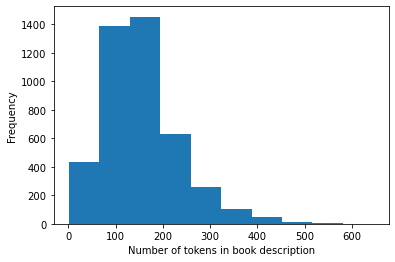

In [21]:
plt.hist(temp_df['num_of_tokens'])
plt.xlabel("Number of tokens in book description")
plt.ylabel("Frequency")
plt.show()

In [22]:
## Take 100 sentences to demonstrate BERT embeddings
sent_series= temp_df["book_desc_tok_short"].progress_apply(lambda x:re.split('\.',x))
sent= flatten(sent_series.to_list())

  0%|          | 0/4327 [00:00<?, ?it/s]

In [23]:
sent_series

0       [the incredible national bestseller that is ch...
1       [an ingenious code hidden in the works of leon...
2       [written by spencer johnson coauthor of the on...
3       [a literary sensation and runaway bestseller t...
4       [dark allegory describes the narrator s journe...
                              ...                        
4322    [in the tradition of the girl on the train the...
4323    [nutshell is a classic story of murder and dec...
4324    [minerva was the roman goddess of warriors and...
4325    [why is everyone talking about the ending of s...
4326    [sixteen year old starr carter moves between t...
Name: book_desc_tok_short, Length: 4327, dtype: object

In [24]:
sent_series[0]

['the incredible national bestseller that is changing people s lives and increasing their net worth can you spot the millionaire next door who are the rich in this country what do they do where do they shop what do they drive how do they invest where did their ancestors come from how did they get rich can i ever become one of them get the answers in the millionaire next door the never before told story about wealth in america you ll be surprised at what you find out']

In [25]:
sent

['the incredible national bestseller that is changing people s lives and increasing their net worth can you spot the millionaire next door who are the rich in this country what do they do where do they shop what do they drive how do they invest where did their ancestors come from how did they get rich can i ever become one of them get the answers in the millionaire next door the never before told story about wealth in america you ll be surprised at what you find out',
 'an ingenious code hidden in the works of leonardo da vinci a desperate race through the cathedrals and castles of europe an astonishing truth concealed for centuries unveiled at last while in paris harvard symbologist robert langdon is awakened by a phone call in the dead of the night the elderly curator of the louvre has been murdered inside the museum his body covered in baffling symbols as langdon and gifted french cryptologist sophie neveu sort through the bizarre riddles they are stunned to discover a trail of clue

In [26]:
len(sent)

4327

In [27]:
sent[0:3]

['the incredible national bestseller that is changing people s lives and increasing their net worth can you spot the millionaire next door who are the rich in this country what do they do where do they shop what do they drive how do they invest where did their ancestors come from how did they get rich can i ever become one of them get the answers in the millionaire next door the never before told story about wealth in america you ll be surprised at what you find out',
 'an ingenious code hidden in the works of leonardo da vinci a desperate race through the cathedrals and castles of europe an astonishing truth concealed for centuries unveiled at last while in paris harvard symbologist robert langdon is awakened by a phone call in the dead of the night the elderly curator of the louvre has been murdered inside the museum his body covered in baffling symbols as langdon and gifted french cryptologist sophie neveu sort through the bizarre riddles they are stunned to discover a trail of clue

In [28]:
temp_df['sent'] = sent

### Tokenization

In [29]:
#tokenize the sentences -- 
# break them up into words and subwords in the format BERT is comfortable with
tokenized = temp_df['sent'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  0%|          | 0/4327 [00:00<?, ?it/s]

In [30]:
tokenized.shape

(4327,)

In [31]:
#temp_df['tokenized']=tokenized

### Padding

After tokenization, tokenized is a list of sentences.
Each sentence is represented as a list of tokens.
We want BERT to process our examples all at once (as one batch), which is why we need to pad all lists to the same size, so we can represent the input as one 2D array.

Reference: https://www.kaggle.com/nikhil00/eda-use-bert-recommendation-system

In [32]:
max_len = 0
for i in tqdm(tokenized.values):
    #figuring out the maximum length of any sentence in 'tokenized'
    if len(i) > max_len:
        max_len = len(i)

print('Max Number of Tokens in Single Input = '+ str(max_len))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  0%|          | 0/4327 [00:00<?, ?it/s]

Max Number of Tokens in Single Input = 509


In [33]:
padded.shape

(4327, 509)

In [34]:
padded[0:3]

array([[ 102,  111,  529, ...,    0,    0,    0],
       [ 102,  130, 5520, ...,    0,    0,    0],
       [ 102, 4293,  214, ...,    0,    0,    0]])

### Masking

If we directly send padded to BERT, that would confuse it a little.
We need to create another variable to tell it to ignore (mask) the padding added. That's what attention_mask is:

In [35]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(4327, 509)

In [36]:
attention_mask[0:3]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [37]:
input_ids = torch.tensor(padded)  

In [38]:
attention_mask = torch.tensor(attention_mask)

BERT: transformer made of several similar layers stacked on top of each other.
Each layer has an input and an output.

The output of the layer *n-1* is the input of the layer *n*.
The hidden state is the output. of each layer.

In [101]:
#no_grad: gradient calculation disabled
# model (obj): embedding model to generate embeddings from token and segment ids



In [ ]:
with torch.no_grad():
    #You should pass along small batches to the model to avoid this error: you should create a loop that goes over the I in range(0, len(padded), batch_size) and passes along the padded[i: i+batch_size] to your model, then concatenates the predictions back together.

    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
embeddings = last_hidden_states[0][:,0,:].numpy()


In [ ]:
embeddings.shape


In [ ]:
embeddings

In [ ]:
embeddings_df = pd.DataFrame(embeddings)

In [ ]:
embeddings_df

In [ ]:
embeddings_df.to_csv('book_embeddings_from_bert.csv')